In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import wrangle

In [3]:

df = pd.read_csv('student_grades.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   104 non-null    int64  
 1   exam1        103 non-null    float64
 2   exam2        104 non-null    int64  
 3   exam3        104 non-null    object 
 4   final_grade  104 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ KB


In [5]:
df = wrangle.wrangle_grades()

In [6]:
df.head()

,exam1,exam2,exam3,final_grade
0,100,90,95,96
1,98,93,96,95
2,85,83,87,87
3,83,80,86,85
4,93,90,96,97


In [7]:
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [8]:
X_train = train.drop(columns='final_grade')
y_train = train[['final_grade']]

X_validate = validate.drop(columns="final_grade")
y_validate = validate[["final_grade"]]

X_test = test.drop(columns='final_grade')
y_test = test[['final_grade']]

In [9]:
#scale our data

In [10]:
import sklearn.preprocessing


In [11]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [13]:
y_train.head()

,final_grade
10,68
15,87
42,85
51,72
46,76


In [15]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [16]:
#Create a baseline

In [17]:
baseline = y_train.mean()
print(baseline)

final_grade    81.631579
dtype: float64


In [18]:
#Feature Elimination

In [19]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 2)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train) 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Get a list of the features we have selected

In [21]:
# boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: exam1, exam3


In [22]:
#Multiple linear regression model

In [24]:
lm = LinearRegression()
lm.fit(X_rfe, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [12.14476092]
features:  Index(['exam1', 'exam3'], dtype='object')
coefficients:  [[0.59343236 0.27423512]]


In [26]:
#Get the predicted values

In [27]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,final_grade,yhat_lm
10,68,65.760296
15,87,86.444967
42,85,84.983867
51,72,75.075365
46,76,76.032957


In [28]:
#Evaluate the RMSE

In [29]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_lm))
RMSE_lm

print("linear model\n  Root mean squared error: {:.3}".format(RMSE_lm))

linear model
  Root mean squared error: 1.65


In [30]:
#Return the coefficient

In [31]:
r2_lm = lm.score(X_rfe, y_train.final_grade)

print(f'{r2_lm:.2%} of the variance in the student''s final grade can be explained by the grades on exam 1 and 3.')

97.49% of the variance in the students final grade can be explained by the grades on exam 1 and 3.


In [32]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
print(output)

final_grade = 12.14 + 0.59 * exam1 + 0.274 * exam3


In [33]:
#Polynomial Regression Model

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [35]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.final_grade)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
#RMSE

In [37]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_poly))
RMSE_poly

print("polynomial model\n  Root mean squared error: {:.3}".format(RMSE_poly)) 



polynomial model
  Root mean squared error: 1.28


In [38]:
#Baseline Model

In [39]:
# set predictions to be the mean of all final grades
y_train['yhat_baseline'] = df['final_grade'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_baseline))
print("Baseline (ŷ = ȳ)\n  Root mean squared error: {:.3}".format(RMSE_bl)) 

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.final_grade, y_train.yhat_baseline)
print('  {:.2%} of the variance in the student''s final grade can be explained by the grades on exam 1 and 3.'.format(evs))

Baseline (ŷ = ȳ)
  Root mean squared error: 10.4
  0.00% of the variance in the students final grade can be explained by the grades on exam 1 and 3.


In [40]:
#Putting it together

In [41]:
y_train.head()

,final_grade,yhat_lm,yhat_poly,yhat_baseline
10,68,65.760296,67.187419,81.970588
15,87,86.444967,85.564223,81.970588
42,85,84.983867,84.280514,81.970588
51,72,75.075365,75.097629,81.970588
46,76,76.032957,76.324583,81.970588


Text(0.5, 1.0, 'Predicted vs Actual Final Grade')

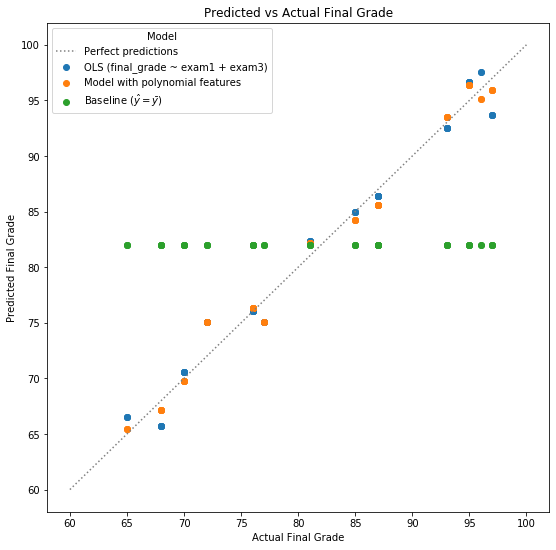

In [42]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.final_grade, y_train.yhat_lm, label='OLS (final_grade ~ exam1 + exam3)', marker='o')
plt.scatter(y_train.final_grade, y_train.yhat_poly, label='Model with polynomial features', marker='o')
plt.scatter(y_train.final_grade, y_train.yhat_baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')
plt.plot([60, 100], [60, 100], label='Perfect predictions', ls=':', c='grey')

plt.legend(title='Model')
plt.ylabel('Predicted Final Grade')
plt.xlabel('Actual Final Grade')
plt.title('Predicted vs Actual Final Grade')

In [43]:
##Try it on Telco dataset

In [44]:
df = wrangle.wrangle_telco()

In [45]:
df.head()

,monthly_charges,tenure,Two year,total_charges
1793,90.45,65,1,5879.25
1794,45.20,54,1,2440.80
1795,45.05,56,1,2522.80
1796,39.40,20,1,788.00
1797,85.15,72,1,6130.80


In [46]:
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [47]:
X_train = train.drop(columns='tenure')
y_train = train[['tenure']]

X_validate = validate.drop(columns='tenure')
y_validate = validate[['tenure']]

X_test = test.drop(columns='tenure')
y_test = test[['tenure']]

In [48]:
#scale our data

In [49]:
import sklearn.preprocessing

In [50]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [51]:
y_train.head()

,tenure
2352,60
5400,72
6668,62
5347,72
6560,38


In [52]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [53]:
#Create a baseline

In [54]:
baseline = y_train.mean()
print(baseline)

tenure    56.972718
dtype: float64


In [55]:
#Feature Elimination

In [56]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 2)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train) 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
#Get a list of the feautres we have selected

In [58]:
# boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: monthly_charges, total_charges


In [59]:
#Multiple linear regression model

In [60]:
lm = LinearRegression()
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [52.25508011]
features:  Index(['monthly_charges', 'total_charges'], dtype='object')
coefficients:  [[-0.89133481  0.01581113]]


In [63]:
#Predict the y values

In [64]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tenure,yhat_lm
2352,60,55.090203
5400,72,80.531865
6668,62,53.963024
5347,72,79.345945
6560,38,46.386742


In [65]:
#Calculate the RMSE

In [67]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.tenure, y_train.yhat_lm))
RMSE_lm

print("linear model\n  Root mean squared error: {:.3}".format(RMSE_lm))

linear model
  Root mean squared error: 9.71


In [68]:
#Return the coefficient

In [70]:
r2_lm = lm.score(X_rfe, y_train.tenure)

print(f'{r2_lm:.2%} of the variance in tenure can be explained by the monthly and total charges.')

72.88% of the variance in tenure can be explained by the monthly and total charges.


In [71]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
print(output)

tenure = 52.26 + -0.89 * monthly_charges + 0.0158 * total_charges


In [72]:
#Polynomial Regression Model

In [73]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [74]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.tenure)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
#Root mean squared error

In [76]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.tenure, y_train.yhat_poly))
RMSE_poly

print("polynomial model\n  Root mean squared error: {:.3}".format(RMSE_poly))

polynomial model
  Root mean squared error: 4.23


In [77]:
#Baseline Model

In [78]:
# set predictions to be the mean of tenure
y_train['yhat_baseline'] = df['tenure'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.tenure, y_train.yhat_baseline))
print("Baseline (ŷ = ȳ)\n  Root mean squared error: {:.3}".format(RMSE_bl)) 

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.tenure, y_train.yhat_baseline)
print('  {:.2%} of the variance in tenure can be explained by the monthly and total charges.'.format(evs))

Baseline (ŷ = ȳ)
  Root mean squared error: 18.6
  0.00% of the variance in tenure can be explained by the monthly and total charges.


In [79]:
#Put it together

In [80]:
y_train.head()

,tenure,yhat_lm,yhat_poly,yhat_baseline
2352,60,55.090203,57.954274,56.735103
5400,72,80.531865,68.502739,56.735103
6668,62,53.963024,59.034535,56.735103
5347,72,79.345945,70.102941,56.735103
6560,38,46.386742,40.647003,56.735103


In [81]:
########## Workflow of Maggie's notebook #############

Linear Regression

In [88]:
df = wrangle.wrangle_telco()

In [89]:
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [90]:
X_train = train.drop(columns='tenure')
y_train = train[['tenure']]

X_validate = validate.drop(columns='tenure')
y_validate = validate[['tenure']]

X_test = test.drop(columns='tenure')
y_test = test[['tenure']]

In [91]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [82]:
# Fit the model

In [92]:
lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [93]:
# Predict our training observations

In [94]:
lm_pred = lm.predict(X_train_scaled)


In [95]:
# Evaluate our training predictions

In [96]:
# compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

9.705100798265981

In [97]:
#Predict our validate observations

In [98]:
lm_pred_v = lm.predict(X_validate_scaled)

In [99]:
#Evaluate our validate predictions

In [101]:
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

9.27937755845321

LassoLars()

In [102]:
#Fit the model using the training dataset

In [103]:
lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [104]:
#Predict our training obervations

In [105]:
lars_pred = lars.predict(X_train_scaled)


In [107]:
#Evaluate our training predictions

In [108]:
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

14.598312333596384

In [109]:
#Predict our validation observations

In [110]:
lars_pred_v = lars.predict(X_validate_scaled)


In [112]:
#Evaluate our validation predictions


In [114]:
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

13.436004209351887

PolynomialFeatures + LinearRegression

- Create the new features, which are our original features squared.
- fit the Linear Regression model
- Predict on train
- Evaluate on train
- transform our validate features to make them squared
- predict on validate
- evaluate on validate.

In [117]:
#Create the object

In [118]:
pf = PolynomialFeatures(degree=2)


In [119]:
#fit and transform, which are the original features squared

In [120]:
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)

In [121]:
#fit the data into the linear model

In [122]:
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
#Predict our training observations

In [124]:
lm_squared_pred = lm_squared.predict(X_train_squared)


In [125]:
#Evaluate our training predictions

In [126]:
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

4.233949161503175

In [128]:
#Predict our validation observations

In [129]:
lm_squared_pred_v = lm_squared.predict(X_validate_squared)


In [130]:
#Evaluate our validation predictions

In [131]:
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

4.643484881162845

In [132]:
##Polynomial is the best model, so going to run on test data

In [134]:
lm_pred_test = lm.predict(X_test_scaled)
lm_rmse_test = mean_squared_error(y_test, lm_pred_test)**(1/2)
lm_rmse_test

9.548086564455167

In [138]:
baseline = df.tenure.mean()
print(baseline)

56.73510324483776


In [139]:
#Evaluate and compare

In [143]:
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
# lm_cubed_rmse = mean_squared_error(y_train, lm_cubed_pred)**(1/2)

print("Baseline, Mean: ", baseline)
print("Linear Model: ", lm_rmse)
print("LassoLars: ", lars_rmse)
print("Polynomial, squared: ", lm_squared_rmse)
# print("Polynomial, cubed: ", lm_cubed_rmse)

Baseline, Mean:  56.73510324483776
Linear Model:  9.705100798265981
LassoLars:  14.598312333596384
Polynomial, squared:  4.233949161503175
